In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
from vit import VisionTransformer
from utils import get_n_params, device, imshow
device

'cuda'

In [2]:
data_args = {
    'batch_size': 32,
    'num_worker': 8,
    'valid_size': 0.2
}

print('==> Preparing the data')
transforms_train = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transforms_valid = transforms.Compose([
	transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_train = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transforms_train)
dataset_valid = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transforms_valid)

num_train = len(dataset_train)
indices = list(range(num_train))
split = int(np.floor(data_args['valid_size'] * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=data_args['batch_size'],
	                      num_workers=data_args['num_worker'], sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=data_args['batch_size'],
	                      num_workers=data_args['num_worker'], sampler=valid_sampler)


len_train_data = len(train_loader)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
	       'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing the data


100%|██████████| 170498071/170498071 [00:13<00:00, 12974294.90it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


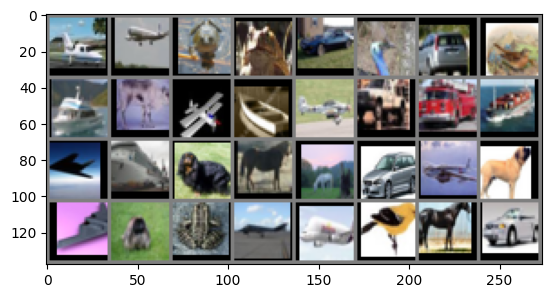

plane plane frog  frog  car   bird  car   bird  ship  deer  plane ship  plane truck truck ship  plane ship  dog   horse horse car   plane dog   plane dog   frog  plane plane bird  horse car  


In [3]:
# get some random training images
images, labels = next(iter(train_loader))
_, num_ch, size, _ = images.shape

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(data_args['batch_size'])))

In [27]:
model_cfg = {
    "img_size": size,
    "in_chans": num_ch,
    "patch_size": 32,
    "embed_dim": 384,
    "depth": 3,
    "n_heads": 3,
    "qkv_bias": True,
    "mlp_ratio": 2,
    "n_classes": len(classes),
    "p": 0.2,
    "attn_p": 0.2
}
train_args = {
    'epoch_nums': 20,
    'print_every': len_train_data // 10,
    'valid_step': 2,
    'save_path': 'weights/vit_best.pth'
}
os.makedirs('weights', exist_ok=True)


model_vit = VisionTransformer(**model_cfg)
if os.path.exists(train_args['save_path']):
  try:
    model_vit.load_state_dict(torch.load(train_args['save_path']))
    print('Model loaded successfully')
  except:
    pass

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vit.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
print(f'The current model has {get_n_params(model_vit)} parameters')

Model loaded successfully
The current model has 4737418 parameters


# Training

In [28]:
min_val_loss = 1e20
train_losses = []
val_losses = []

for epoch in range(1, train_args["epoch_nums"] + 1):
    print('==> Starting the training loop')
    model_vit.train().to(device)
    running_train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader, 1):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_vit(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_losses.append(loss.item())
        if batch_idx % train_args["print_every"] == 0:
            print(f'epoch {epoch} [{batch_idx}/{len_train_data}]| loss: {running_train_loss/(train_args["print_every"]):.3f}, lr: {optimizer.param_groups[0]["lr"]}')
            running_train_loss = 0

    if epoch % train_args["valid_step"] == 0:
        print('====> Validating the model')
        model_vit.eval()
        running_val_loss = 0

        for batch_idx, (inputs, targets) in enumerate(valid_loader, 1):
            inputs = inputs.to(device)
            targets = targets.to(device)
            with torch.no_grad():
                outputs = model_vit(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()
            val_losses.append(loss.item())
        mean_val_loss = running_val_loss / len(valid_loader)
        print(f'Mean val loss is {mean_val_loss:.3f}')
        if mean_val_loss < min_val_loss:
            min_val_loss = mean_val_loss
            torch.save(model_vit.cpu().state_dict(), train_args['save_path'])
            print('Model saved')

    scheduler.step()

==> Starting the training loop


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 1 [125/1250]| loss: 1.607, lr: 0.001
epoch 1 [250/1250]| loss: 1.626, lr: 0.001
epoch 1 [375/1250]| loss: 1.579, lr: 0.001
epoch 1 [500/1250]| loss: 1.613, lr: 0.001
epoch 1 [625/1250]| loss: 1.613, lr: 0.001
epoch 1 [750/1250]| loss: 1.571, lr: 0.001
epoch 1 [875/1250]| loss: 1.579, lr: 0.001
epoch 1 [1000/1250]| loss: 1.593, lr: 0.001
epoch 1 [1125/1250]| loss: 1.604, lr: 0.001
epoch 1 [1250/1250]| loss: 1.634, lr: 0.001
==> Starting the training loop
epoch 2 [125/1250]| loss: 1.604, lr: 0.001
epoch 2 [250/1250]| loss: 1.607, lr: 0.001
epoch 2 [375/1250]| loss: 1.575, lr: 0.001
epoch 2 [500/1250]| loss: 1.599, lr: 0.001
epoch 2 [625/1250]| loss: 1.626, lr: 0.001
epoch 2 [750/1250]| loss: 1.633, lr: 0.001
epoch 2 [875/1250]| loss: 1.618, lr: 0.001
epoch 2 [1000/1250]| loss: 1.613, lr: 0.001
epoch 2 [1125/1250]| loss: 1.579, lr: 0.001
epoch 2 [1250/1250]| loss: 1.581, lr: 0.001
====> Validating the model
Mean val loss is 1.522
Model saved
==> Starting the training loop
epoch 3 [1

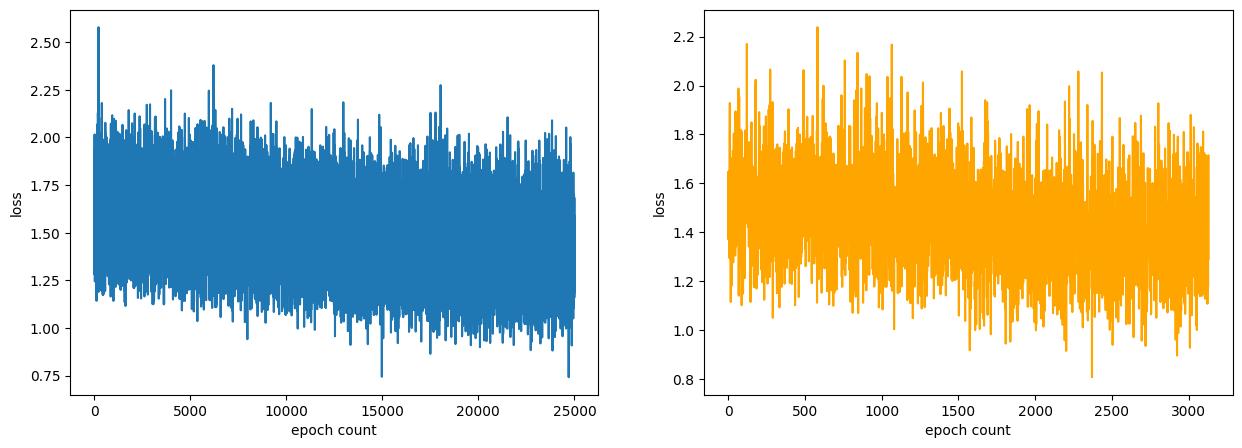

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch count')

axs[1].plot(val_losses, c='orange')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch count')
plt.show();